# Assessing Utilization
We want to measure how much the system was utilized for different types of loads.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import json
import re
params = {'legend.fontsize': 8,
         'axes.labelsize': 9,
         'axes.titlesize':'x-large',
         'xtick.labelsize': 6,
         'ytick.labelsize': 6}
plt.rcParams.update(params)

## Get the Runs
Load in the different runs that are part of this benchmarking effort

In [2]:
runs = list(Path("./runs/").rglob("config.json"))
print(f'Found {len(runs)} runs')

Found 52 runs


Summarize the runs

In [3]:
def summarize_run(path: Path):
    """Get some details about the run"""
    
    with open(path) as fp:
        config = json.load(fp)
    
    config['path'] = path.parent
    config['host'] = path.parent.name.rsplit("-", 5)[0]
    return config

In [4]:
results = pd.DataFrame(summarize_run(x) for x in runs)

## Assess Utilization
Our goal is to measure the utilization at "steady state" after all workers have finished loading in libraries.

We do so by looking at how busy each worker is.
We can measure this by starting the clock on utilization when the first task completes and ending it when the last result finishes.
Utilization for that node is the total time compute was running devided by the time elapsed.

In [5]:
def get_utilization(path: Path):
    """Measure the average utilization of this run"""
    
    # Get the results for each worker
    results = pd.read_json(path / "results.json", lines=True)
    
    if len(results) == 0:
        return None
    results['worker'] = results['worker_info'].apply(lambda x: f'{x["hostname"]}-{x["PARSL_WORKER_RANK"]}')
    
    # Compute utilization per worker
    utils = []
    results = pd.concat([results, pd.json_normalize(results['timestamp'], sep="_")], axis=1)
    for gid, group in results.groupby('worker'):
        group.sort_values('created', inplace=True)

        # Get the total time running
        start_time = group.iloc[0]['compute_ended']
        end_time = group.iloc[-1]['compute_ended']
        time_elapsed = end_time - start_time

        # Get the total time used
        compute_used = group.iloc[1:]['time'].apply(lambda x: x['running']).sum()

        utils.append(compute_used / time_elapsed)
    
    return np.mean(utils)

In [6]:
results['utilization'] = results['path'].apply(get_utilization)

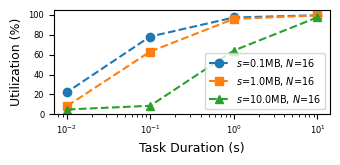

In [7]:
fig, ax = plt.subplots(figsize=(3.5, 1.75))

for (gid, group), m in zip(results.query('host=="bettik-linux"').groupby(['task_input_size', 'parallel_tasks']), ['o', 's', '^', 'v']):
    group.sort_values(['task_length', 'utilization'], ascending=False, inplace=True)
    group.drop_duplicates('task_length', inplace=True, keep='first')
    ax.semilogx(group['task_length'], group['utilization'] * 100, '--'+m, label=f'$s$={gid[0]}MB, $N$={gid[1]}')

ax.set_ylim(0, 105)
ax.set_ylabel('Utilization (%)')
ax.set_xlabel('Task Duration (s)')
ax.legend(fontsize=7)

fig.tight_layout()
fig.savefig('performance-envelope.pdf')

## Measure the Response, Decision, and Dispatch Times
We can measure three sources of latency for applications using the logs in the `Result` object for response and dispatch, and the Colmena logs for the reaction time

In [8]:
def get_median_reaction_time(path: Path):
    """Measure the median reaction time for all tasks, total and data-related, 
    broken down by compute and data transit"""

    # Loop over the tasks
    compute = []
    data = []
    with path.joinpath('results.json').open() as fp:
        for line in fp:
            record = json.loads(line)
            compute_time = (
                record['timestamp']['result_received'] -
                record['timestamp']['compute_ended']
            )  # Time for the compute message to arrive
            compute.append(compute_time)

            # Additional time to read the data
            data_time = compute_time + record['task_info']['read_time']
            data.append(data_time)

    if len(compute) > 0:
        return np.percentile(compute, 50), np.percentile(data, 50)
    return -1, -1

In [9]:
results['rxn_time_compute'], results['rxn_time_data']  = zip(*results['path'].apply(get_median_reaction_time))

In [10]:
def get_median_decision_time(path: Path):
    """Measure the median time for all job submissions."""

    decision_time = []
    pat = re.compile('Finished submitting new work. Runtime: (\d\.\d+e-?\d+)s')
    with path.joinpath('run.log').open() as fp:
        for line in fp:
            for match in pat.findall(line):
                decision_time.append(float(match))
    return np.percentile(decision_time, 50)    

In [11]:
results['decision_time'] = results['path'].apply(get_median_decision_time)

In [12]:
def get_median_dispatch_time(path: Path):
    """Measure the median dispatch time for all tasks,
    by until the compute message arrives and when the data arrives"""

    # Loop over the tasks
    compute = []
    data = []
    with path.joinpath('results.json').open() as fp:
        for line in fp:
            record = json.loads(line)
            compute_time = (
                record['timestamp']['compute_started'] 
                - record['timestamp']['created']
                + record['time']['deserialize_inputs']
            )
            compute.append(compute_time)

            # Add the additional time taken for the data to be accessed
            data_time = 0
            for proxy, timings in record['time'].get('proxy', {}).items():
                if 'store.get' in timings['times']:
                    data_time += timings['times']['store.get']['avg_time_ms'] / 1000
            data.append(
                compute_time + data_time
            )

    return np.percentile(compute, 50), np.percentile(data, 50)

In [ ]:
results['dispatch_time_compute'], results['dispatch_time_data']  = zip(*results['path'].apply(get_median_dispatch_time))

In [ ]:
fig, axs = plt.subplots(3, sharex=True, figsize=(3.5, 2.6))

subset = results[results.path.apply(lambda x: x.name.startswith('x'))].query('task_input_size==10 and task_length==10')
subset = subset.sort_values('parallel_tasks').drop_duplicates('parallel_tasks', keep='first')

ls = dict(marker='x', linestyle='--', ms=5, color='blue')

# Plot the reaction time, with total and compute
ax = axs[0]
ax.loglog(subset['parallel_tasks'], subset['rxn_time_data'] * 1000, **ls)
ax.fill_between(subset['parallel_tasks'], subset['rxn_time_compute'] * 1000, color='gray')

# Plot the decision time
ax = axs[1]
ax.plot(subset['parallel_tasks'], subset['decision_time'] * 1000, **ls)

# Plot the dispatch time, with total and compute
ax = axs[2]
ax.plot(subset['parallel_tasks'], subset['dispatch_time_data'] * 1000, **ls)
ax.fill_between(subset['parallel_tasks'], subset['dispatch_time_compute'] * 1000, color='gray')

# Labels
for ax, l in zip(axs, ['Reaction', 'Decision', 'Dispatch']):
    ax.text(0.01, 0.5 if l == 'Decision' else 0.97, l, fontsize=7, ha='left', va='top', 
           transform=ax.transAxes)
    
    ax.set_ylabel('Time (ms)', fontsize=8)
ax.set_xlabel('Worker Count', fontsize=8)

axs[-1].set_xscale('log', base=2)

fig.tight_layout()
fig.savefig('reaction-times.png', dpi=320)
fig.savefig('reaction-times.pdf')